# The Daubechies D4 Wavelet Tranform

In [8]:
import numpy as np
import cv2
import IPython
from PIL import Image
import matplotlib.pyplot as plt
from time import time


def split_matrix(mat): # divide the matrix into 4 quadrants
    h, w = mat.shape
    return mat[:h // 2, :w // 2], mat[:h // 2, w // 2:], mat[h // 2:, :w // 2], mat[h // 2:, w // 2:]

def concatenate_matrices(m1, m2, m3, m4):
    return np.concatenate((np.concatenate((m1, m2), axis=1),
                            np.concatenate((m3, m4), axis=1)), axis=0)

def imshow(image, width=None):
    _, ret = cv2.imencode('.jpg', image)
    i = IPython.display.Image(data=ret, width=width)
    IPython.display.display(i)

def jpg_to_pgm(jpg_path):
    image = Image.open(jpg_path)
    image_gray = image.convert('L')
    width = image_gray.size[0]
    if (width>512):
        image_gray = image_gray.resize((512, 512))
        pixels = list(image_gray.getdata())

    else: pixels = list(image_gray.getdata())

    return np.array(pixels).reshape((512, 512))

def new_p(matrix):
    max,min  = np.max(matrix), np.min(matrix)
    for i in range(len(matrix)):
        for j in range(len(matrix[i])):
            matrix[i][j] = ((matrix[i][j]-min)*255.0)/(max-min)
    return matrix


def function_daubechies_coeffs(image):
    rows, cols = image.shape
    matrix_coeffs = np.zeros((rows, cols))

    for i in range(rows // 2):
        if i < rows // 2 - 1: 
            matrix_coeffs[i, 2 * i:2 * i + 4] = h_coeffs
        else:
            matrix_coeffs[i, 2 * i:2 * i + 2] = h_coeffs[:2]
            matrix_coeffs[i, 0:2] = h_coeffs[2:]

    for i in range(rows // 2):
        if i < rows // 2 - 1:
            matrix_coeffs[i + rows // 2, 2 * i:2 * i + 4] = g_coeffs
        else:
            matrix_coeffs[i + rows // 2, 2 * i:2 * i + 2] = g_coeffs[:2]
            matrix_coeffs[i + rows // 2, 0:2] = g_coeffs[2:]

    return (np.round(matrix_coeffs, 4))
     
     
root2, root3 = np.sqrt(2), np.sqrt(3) 

h_coeffs = np.array([(1 + root3) / (4 * root2),
                     (3 + root3) / (4 * root2),
                     (3 - root3) / (4 * root2),
                     (1 - root3) / (4 * root2)])

g_coeffs = np.array([h_coeffs[3], 
                    -h_coeffs[2],
                     h_coeffs[1], 
                    -h_coeffs[0]])

In [9]:
def daubechies4_wavelet_transform_2D(daubechies_coeffs,image,scale,width, details = None):
    result_H = []

    for row in image: #ESTA PARTE HACE LA HORIZONTAL
        result_H.append(np.dot(daubechies_coeffs,row))
    result_V = np.dot(daubechies_coeffs,result_H)

    if (scale == 1) :
        normalized = np.copy(result_V)
        aP,cH,cV,cD = split_matrix(normalized)
        normalized = concatenate_matrices(new_p(aP),new_p(cH),new_p(cV),new_p(cD))
        if details is not None:
            for i in range(len(details)//3):
                result_V = concatenate_matrices(result_V,details[0+(i*3)],details[1+(i*3)],details[2+(i*3)])
                normalized = concatenate_matrices(new_p(normalized),new_p(details[0+(i*3)]),new_p(details[1+(i*3)]),new_p(details[2+(i*3)])) ########
  
            return result_V, normalized
        else:
            return result_V, normalized
        
    elif (np.log2(width//4) >= scale > 1):
        aP,cH,cV,cD = split_matrix(result_V)
        details = ([cH,cV,cD] + details) if details is not None else [cH,cV,cD]
        return daubechies4_wavelet_transform_2D(function_daubechies_coeffs(aP),aP,scale-1,aP.shape[0],details)

    else : print(f"Error. The scale value has to be between 1 - {int(np.log2(width//4))}"); return np.ones_like(image), np.ones_like(image)

In [10]:
def new_matrix(matriz, pix):
    n = len(matriz)
    nueva_matriz = matriz[:pix, :pix]
    
    return nueva_matriz

def concatenar(matriz_grande, matriz_pequena):
    n = len(matriz_pequena)
    matriz_grande[:n, :n] = matriz_pequena
    
    return matriz_grande

aux = 0

def inverse_daubechies4_wavelet_transform_2D(daubechies_coeffs, transform_result,scale,width, details = None):

    if (scale == 1) :

        daubechies_coeffs_transpose = np.transpose(daubechies_coeffs)
        result_H = np.dot(daubechies_coeffs_transpose, transform_result)

        image = []
        for row in result_H:
            original_row = np.dot(daubechies_coeffs_transpose, row)
            image.append(original_row)
            
        return np.array(image)
    
    else: 
        tam_aprox = width // (2 ** scale)
        tam_img = tam_aprox * 2
        new_img = new_matrix(transform_result, (tam_img))
        scale = scale - 1

        daubechies_coeffs_transpose = np.transpose(function_daubechies_coeffs(new_img))
        result_H = np.dot(daubechies_coeffs_transpose, new_img)

        image = []
        for row in result_H:
            original_row = np.dot(daubechies_coeffs_transpose, row)
            image.append(original_row)

       
        image = concatenar(transform_result,image)

        return inverse_daubechies4_wavelet_transform_2D(function_daubechies_coeffs(image),image,scale,len(image))



In [11]:
def zeros(image, scale):
    width = len(image)
    tam_aprox = width // (2 ** scale)
    tam_img = tam_aprox * 2

    image[:tam_img, :tam_img] = np.zeros((tam_img, tam_img))
    return image



## NUMERICS EXAMPLE

In [12]:
example = np.random.randint(0.0, 52.0, (8, 8))
example_daubechies_4 = function_daubechies_coeffs(example)
example_daubechies_4_transposed = np.transpose(example_daubechies_4)
print(f"\nCoeffs Matrix:\n {example_daubechies_4}")
print(f"\nCoeffs Matrix Transposed:\n {example_daubechies_4_transposed}")


Coeffs Matrix:
 [[ 0.483   0.8365  0.2241 -0.1294  0.      0.      0.      0.    ]
 [ 0.      0.      0.483   0.8365  0.2241 -0.1294  0.      0.    ]
 [ 0.      0.      0.      0.      0.483   0.8365  0.2241 -0.1294]
 [ 0.2241 -0.1294  0.      0.      0.      0.      0.483   0.8365]
 [-0.1294 -0.2241  0.8365 -0.483   0.      0.      0.      0.    ]
 [ 0.      0.     -0.1294 -0.2241  0.8365 -0.483   0.      0.    ]
 [ 0.      0.      0.      0.     -0.1294 -0.2241  0.8365 -0.483 ]
 [ 0.8365 -0.483   0.      0.      0.      0.     -0.1294 -0.2241]]

Coeffs Matrix Transposed:
 [[ 0.483   0.      0.      0.2241 -0.1294  0.      0.      0.8365]
 [ 0.8365  0.      0.     -0.1294 -0.2241  0.      0.     -0.483 ]
 [ 0.2241  0.483   0.      0.      0.8365 -0.1294  0.      0.    ]
 [-0.1294  0.8365  0.      0.     -0.483  -0.2241  0.      0.    ]
 [ 0.      0.2241  0.483   0.      0.      0.8365 -0.1294  0.    ]
 [ 0.     -0.1294  0.8365  0.      0.     -0.483  -0.2241  0.    ]
 [ 0.      0.   

In [13]:
print(f"Original Matrix:\n {example}\n")
aP,cH,cV,cD = split_matrix(example)

dwt, normal = daubechies4_wavelet_transform_2D(example_daubechies_4,example,1,example.shape[0])
# idwt = inverse_daubechies4_wavelet_transform_2D(example_daubechies_4,dwt,2,dwt.shape[0])
print(f"\n {np.round(dwt,0)}")
print(f"\n {np.round(new_p(dwt),0)}")
# print(f"\n {np.round(idwt,0)}")

Original Matrix:
 [[14 45  6 49 41 51 48 41]
 [43 34 45 37 44 25 45 31]
 [33 42 11  2 43 24  6 49]
 [12 25 20 41 41 37 48 30]
 [28 27 43  5 31 22 19 36]
 [48  0  0 29 39  9 28 21]
 [ 7 43 23  9 10  2 46 22]
 [11 33 10 28  6 26 41 33]]


 [[ 73.  69.  74.  75.  -9.  12.   3.  -6.]
 [ 55.  49.  69.  66.  -3.  14.  -7. -19.]
 [ 44.  42.  40.  58.  -3.  25.   4.  23.]
 [ 49.  35.  40.  61. -17. -13.  22. -35.]
 [ 15. -31. -17.  -4.   3.  14. -34.   5.]
 [ 16.  -4.  -4.  -2.  33.  -7. -11. -12.]
 [ 11.  -6. -14.  -6.  12.   3.  16. -19.]
 [ -6.   2.  25.   5. -26.  -4.  -8. -17.]]

 [[251. 241. 252. 255.  61. 110.  89.  69.]
 [209. 196. 242. 235.  74. 114.  65.  38.]
 [183. 179. 175. 215.  76. 139.  92. 136.]
 [195. 162. 175. 224.  42.  51. 132.   0.]
 [116.   9.  41.  73.  88. 115.   4.  94.]
 [118.  73.  71.  78. 158.  65.  57.  55.]
 [107.  67.  50.  67. 109.  89. 119.  37.]
 [ 68.  86. 140.  94.  21.  73.  62.  43.]]


## IMAGES EXAMPLES

In [14]:
photo = 'imagen.jpg'

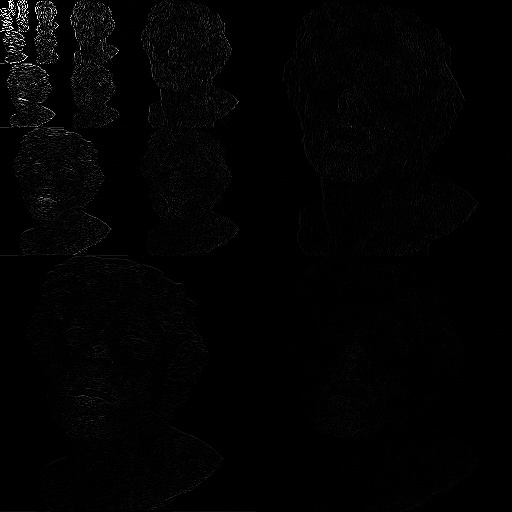

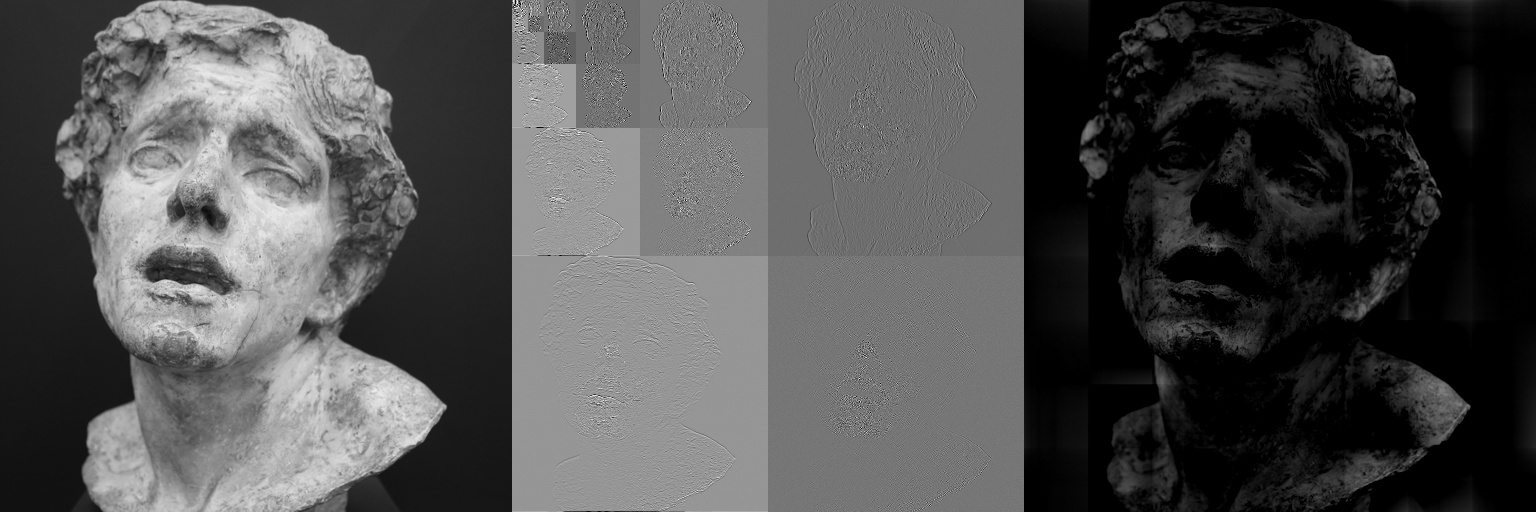

0.9213166236877441


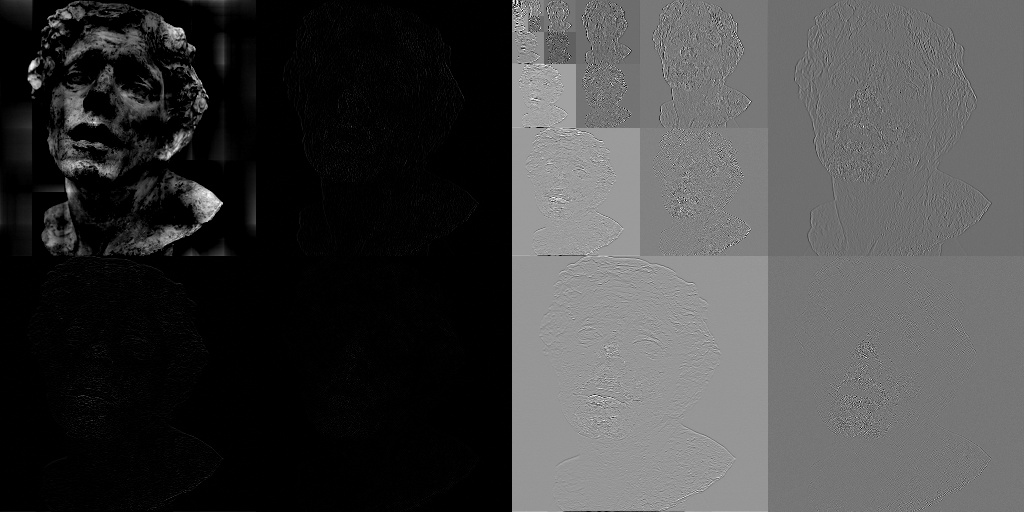

In [15]:
initial_time = time() 
array_photo = jpg_to_pgm(photo)
daubechies_4 = function_daubechies_coeffs(array_photo)
scale, width = 7, array_photo.shape[0]
result_img, normalized= daubechies4_wavelet_transform_2D(daubechies_4,array_photo,scale,width)
result_img = zeros(result_img, scale)
imshow(result_img)
reconstructed = inverse_daubechies4_wavelet_transform_2D(daubechies_4,result_img,(scale),width)

imshow(np.concatenate((array_photo,normalized, reconstructed), axis = 1))


# fig, ax = plt.subplots(1, 2, figsize=(10, 10))
# ax[0].imshow(array_photo, cmap='gray')
# ax[0].set_title('Original')
# ax[1].imshow((normalized), cmap='gray')
# ax[1].set_title('Wavelet Transform')
# plt.show()
final_time = time()
execution_time = final_time - initial_time
print(execution_time)
imshow(np.concatenate((result_img,normalized), axis = 1))